# Libraries used

Running Kernel3.9.13 base anaconda

pip install squarify
pip install yellowbrick
pip install plotly
pip install seaborn
pip install lazypredict
pip install pandas_profiling

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns  
import matplotlib.pyplot as plt
import plotly.io as pio
import squarify #treemap
import os
import matplotlib
import warnings

#to enable the inline plotting
%matplotlib inline 

import warnings
warnings.filterwarnings('ignore')

sns.set_style("darkgrid")

In [2]:
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import classification_report

from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.preprocessing import StandardScaler


from scipy.stats import normaltest

from pandas_profiling import ProfileReport

from yellowbrick.classifier import ROCAUC
from yellowbrick.classifier import ClassPredictionError
from yellowbrick.style.palettes import PALETTES, SEQUENCES, color_palette

import lazypredict

warnings.simplefilter(action='ignore', category=FutureWarning)

# 2. Data Collection and Understanding 

## Network file

The network.csv file contains a static picture of the gas pipeline network. Every row corresponds to a pipe and has a unique PipeId identifier. The table has 1.446.529 pipes. 

The columns describe relevant features of each pipe. The complete list is: 

PipeId - unique identifier for the pipe 

Province - Spanish province where the pipe is located 

Town - Town or city where the pipe is located 

YearBuilt - Year in which the pipe was built and installed 

Material - Material in which the pipe is built 

GasType - Type of gas that runs through the pipe 

Diameter - diameter of the pipe 

Length - Length of the pipe 

Pressure - Pressure of the gas that runs through the pipe (bar) 

NumConnections - Number of connections (external). 

NumConnectionsUnder - Number of connections (internal and buried) 

BoolBridle  - Whether the pipe is bridled (True) or welded (False) 

## Inspection file

MaintenanceId - unique identifier for the inspection operation 

InspectionYear - year in which the inspection took place 

InspectionDate - date in which the inspection took place 

MonthsLastRev - number of months elapsed since the last previous inspection. 

Severity - Severity of the damage found (1: most severe, 3: least severe) 

Incidence - Boolean whether an incident was found on the revision (1) or not (0). 

# Merging datasets

In [10]:
#point to the folder where the data is stored
os.chdir(r"C:\Users\pedro\datathon")


In [8]:

# Loading inspection data
df_inspection = pd.read_csv(r'C:\Users\pedro\datathon\inspections.csv')


In [9]:

# Loading network data
df_network = pd.read_csv(r"C:\Users\pedro\datathon\network.csv")

In [11]:
#merge both dataframes

df_combined = pd.merge(df_inspection, df_network, on="PipeId")

In [12]:
df_combined.head(1)

,PipeId,MaintenanceId,InspectionYear,InspectionDate,MonthsLastRev,Severity,Incidence,Province,Town,YearBuilt,Material,GasType,Diameter,Length,Pressure,NumConnections,NumConnectionsUnder,BoolBridle
0,189311802,ZRV-00001972,2010,2010-10-01,24,4,0,Barcelona,Sentmenat,2001,PE,Gas natural,160.0,117.831,4.0,0,0,False


# Exporting to CSV IS DISABLED!! 
###DO NOT ENABLE THIS AS GIT DOES NOT ALLOW TO PUSH FILES BIGGER THAN 100 MB!!!!
### YOU CAN EXPORT THIS FILE TO ANOTHER DIRECTORY IN YOUR LOCAL MACHINE IF EVER

In [6]:
#CExporting the combined data to csv file
#df_combined.to_csv('df_pipes_combined.csv', index = False)

In [13]:
#creating a subset for altering the dataset after initial EDA
df_combined_mod = df_combined.copy()

## Using Pandas profiling tool for a first feeling of data

Watch out takes 4 minutes to run!

In [8]:
#Creating an EDA using pandas profiling
#profile = ProfileReport(df_combined, title='Pandas Profiling Report', explorative=True)
#profile

# Descriptive EDA on combined dataframe

In [9]:
df_combined['BoolBridle'].describe()

count     6345344
unique          2
top         False
freq      5967747
Name: BoolBridle, dtype: object

In [10]:
# Function for EDA. Using the display() function to have  well-formatted tables. We are mainly using pandas to explore the datasets

def dataset_description(df_target):

    print('This is the Dataset shape: %s\n' % (df_target.shape, ))
    print('Dataset columns: %s\n' % df_target.columns)

    print('\nColumns description:\n')
    display(df_target.info())
    display(df_target.describe())  # describe the dataset

    print('\nNull values:\n')
    display(df_target.isnull().sum())  # Identify null values

In [11]:
dataset_description(df_combined)

This is the Dataset shape: (6345344, 18)

Dataset columns: Index(['PipeId', 'MaintenanceId', 'InspectionYear', 'InspectionDate',
       'MonthsLastRev', 'Severity', 'Incidence', 'Province', 'Town',
       'YearBuilt', 'Material', 'GasType', 'Diameter', 'Length', 'Pressure',
       'NumConnections', 'NumConnectionsUnder', 'BoolBridle'],
      dtype='object')


Columns description:

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6345344 entries, 0 to 6345343
Data columns (total 18 columns):
 #   Column               Dtype  
---  ------               -----  
 0   PipeId               int64  
 1   MaintenanceId        object 
 2   InspectionYear       int64  
 3   InspectionDate       object 
 4   MonthsLastRev        int64  
 5   Severity             int64  
 6   Incidence            int64  
 7   Province             object 
 8   Town                 object 
 9   YearBuilt            int64  
 10  Material             object 
 11  GasType              object 
 12  Diameter             f

None

,PipeId,InspectionYear,MonthsLastRev,Severity,Incidence,YearBuilt,Diameter,Length,Pressure,NumConnections,NumConnectionsUnder
count,6.345344e+06,6.345344e+06,6.345344e+06,6.345344e+06,6.345344e+06,6.345344e+06,6.345344e+06,6.345344e+06,6.345344e+06,6.345344e+06,6.345344e+06
mean,2.031281e+08,2.015609e+03,2.349061e+01,3.997426e+00,1.942842e-03,2.001037e+03,1.195482e+02,3.653018e+01,2.906349e+00,9.842453e-01,2.229982e-04
std,1.137699e+08,2.909342e+00,4.961511e+00,6.451558e-02,4.403484e-02,1.196869e+01,5.721421e+01,7.214106e+01,6.572514e+00,2.140921e+00,1.613866e-02
min,4.896160e+05,2.010000e+03,0.000000e+00,1.000000e+00,0.000000e+00,1.901000e+03,1.000000e+01,0.000000e+00,2.500000e-02,0.000000e+00,0.000000e+00
25%,1.335933e+08,2.013000e+03,2.300000e+01,4.000000e+00,0.000000e+00,1.997000e+03,9.000000e+01,4.005000e+00,1.000000e-01,0.000000e+00,0.000000e+00
50%,1.903213e+08,2.016000e+03,2.400000e+01,4.000000e+00,0.000000e+00,2.003000e+03,1.100000e+02,1.426200e+01,1.500000e-01,0.000000e+00,0.000000e+00
75%,2.981763e+08,2.018000e+03,2.400000e+01,4.000000e+00,0.000000e+00,2.008000e+03,1.600000e+02,4.460100e+01,4.000000e+00,1.000000e+00,0.000000e+00
max,4.519953e+08,2.021000e+03,1.320000e+02,4.000000e+00,1.000000e+00,2.050000e+03,6.096000e+02,2.610094e+04,8.000000e+01,8.800000e+01,4.000000e+00



Null values:



PipeId                 0
MaintenanceId          0
InspectionYear         0
InspectionDate         0
MonthsLastRev          0
Severity               0
Incidence              0
Province               0
Town                   0
YearBuilt              0
Material               0
GasType                0
Diameter               0
Length                 0
Pressure               0
NumConnections         0
NumConnectionsUnder    0
BoolBridle             0
dtype: int64

In [12]:
# Converting Boolbride into categorical boolean variable
def boolbridle(x):
    return 1 if x == 'True' else 0

In [13]:
# Apply function on dataset
df_combined['BoolBridle'] = df_combined['BoolBridle'].apply(lambda x: boolbridle(x))

In [14]:
#showing head and tail
df_combined

,PipeId,MaintenanceId,InspectionYear,InspectionDate,MonthsLastRev,Severity,Incidence,Province,Town,YearBuilt,Material,GasType,Diameter,Length,Pressure,NumConnections,NumConnectionsUnder,BoolBridle
0,189311802,ZRV-00001972,2010,2010-10-01,24,4,0,Barcelona,Sentmenat,2001,PE,Gas natural,160.0,117.831,4.000,0,0,0
1,189311802,ZRV-00001972,2012,2012-10-01,24,4,0,Barcelona,Sentmenat,2001,PE,Gas natural,160.0,117.831,4.000,0,0,0
2,189311802,ZRV-00001972,2014,2014-10-08,24,4,0,Barcelona,Sentmenat,2001,PE,Gas natural,160.0,117.831,4.000,0,0,0
3,189311802,ZRV-00001972,2016,2016-10-14,24,4,0,Barcelona,Sentmenat,2001,PE,Gas natural,160.0,117.831,4.000,0,0,0
4,189311802,ZRV-00001972,2018,2018-10-09,24,4,0,Barcelona,Sentmenat,2001,PE,Gas natural,160.0,117.831,4.000,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6345339,56922448,ZRV-00004581,2020,2020-12-31,24,4,0,Valencia,Betera,1993,PE,Gas natural,63.0,1.237,4.000,0,0,0
6345340,56907425,ZRV-00004581,2020,2020-12-31,24,4,0,Valencia,Betera,2000,PE,Gas natural,160.0,169.732,4.000,1,0,0
6345341,7843615,ZRV-00002112,2021,2020-12-31,24,4,0,Barcelona,Sabadell,1995,FD,Gas natural,150.0,0.361,0.025,0,0,0
6345342,56922456,ZRV-00004581,2020,2020-12-31,24,4,0,Valencia,Betera,1993,PE,Gas natural,63.0,23.306,4.000,0,0,0


In [15]:
#df_combined['day_of_week'] = df_combined['weekday'].dt.day_name()
#Please clarify

In [16]:
#show columns
df_combined.dtypes


PipeId                   int64
MaintenanceId           object
InspectionYear           int64
InspectionDate          object
MonthsLastRev            int64
Severity                 int64
Incidence                int64
Province                object
Town                    object
YearBuilt                int64
Material                object
GasType                 object
Diameter               float64
Length                 float64
Pressure               float64
NumConnections           int64
NumConnectionsUnder      int64
BoolBridle               int64
dtype: object

6 categorical variables, we want to be conservative on hot encoding

In [17]:
print (df_combined['GasType'].unique())

['Gas natural' 'Gas propano']


In [18]:
#hot encode GasType column in the df_combined_mod dataframe subset
df_combined_mod = pd.get_dummies(df_combined, columns=['GasType'], prefix = ['GasType'])

In [19]:
df_combined_mod.head(2)

,PipeId,MaintenanceId,InspectionYear,InspectionDate,MonthsLastRev,Severity,Incidence,Province,Town,YearBuilt,Material,Diameter,Length,Pressure,NumConnections,NumConnectionsUnder,BoolBridle,GasType_Gas natural,GasType_Gas propano
0,189311802,ZRV-00001972,2010,2010-10-01,24,4,0,Barcelona,Sentmenat,2001,PE,160.0,117.831,4.0,0,0,0,1,0
1,189311802,ZRV-00001972,2012,2012-10-01,24,4,0,Barcelona,Sentmenat,2001,PE,160.0,117.831,4.0,0,0,0,1,0


We want to also see materials available for the pipes as a hot encoded feature

In [20]:
print (df_combined['Material'].unique())

['PE' 'AO' 'FD' 'FG' 'PN' 'PA' 'FO' 'FI' 'CU' 'PV' 'ZD']


In [21]:
#Map df_combined Material column to the names of materials

df_combined_mod['Material'] = df_combined_mod['Material'].map({'PE': 'Polyethylene', 'AO': 'Acrylonitrile-Butadiene-Styrene', 'FD': 'Fiberglass-Reinforced Plastic', 'FG': 'Fiberglass', 'PN': 'Polypropylene', 'PA': 'Polyamide', 'FO': 'Flexible Polyolefin', 'FI': 'Flexible Polyvinyl Chloride', 'CU': 'Copper', 'PV': 'Polyvinylidene Fluoride', 'ZD': 'Zinc-Coated Steel', 'ZA': 'Zinc-Aluminum', 'CP': 'Cast Iron', 'CS': 'Cast Steel', 'ZC': 'Zinc-Coated Steel', 'ZM': 'Zinc-Magnesium', 'ZN': 'Zinc', 'AL': 'Aluminum', 'ZP': 'Zinc-Coated Steel', 'ZF': 'Zinc-Aluminum-Magnesium'})



In [22]:
df_combined_mod.tail(2)

,PipeId,MaintenanceId,InspectionYear,InspectionDate,MonthsLastRev,Severity,Incidence,Province,Town,YearBuilt,Material,Diameter,Length,Pressure,NumConnections,NumConnectionsUnder,BoolBridle,GasType_Gas natural,GasType_Gas propano
6345342,56922456,ZRV-00004581,2020,2020-12-31,24,4,0,Valencia,Betera,1993,Polyethylene,63.0,23.306,4.0,0,0,0,1,0
6345343,56922465,ZRV-00004581,2020,2020-12-31,24,4,0,Valencia,Betera,1993,Polyethylene,63.0,1.778,4.0,0,0,0,1,0


In [23]:
#Plotting material before hot encoding
#sns.countplot(df_combined['Material'])

In [24]:
#sns.histplot(x='Material', data=df_combined, kde=True, hue='Severity')
 
#plt.show()

In [25]:
#Hot enconde Material column in the df_combined_mod dataframe subset
df_combined_mod = pd.get_dummies(df_combined_mod, columns=['Material'], prefix = ['Material'])

In [26]:
df_combined_mod.dtypes

PipeId                                        int64
MaintenanceId                                object
InspectionYear                                int64
InspectionDate                               object
MonthsLastRev                                 int64
Severity                                      int64
Incidence                                     int64
Province                                     object
Town                                         object
YearBuilt                                     int64
Diameter                                    float64
Length                                      float64
Pressure                                    float64
NumConnections                                int64
NumConnectionsUnder                           int64
BoolBridle                                    int64
GasType_Gas natural                           uint8
GasType_Gas propano                           uint8
Material_Acrylonitrile-Butadiene-Styrene      uint8
Material_Cop

In [27]:
df_combined_mod['Incidence'].value_counts()

0    6333016
1      12328
Name: Incidence, dtype: int64

In [28]:
df_combined_mod.shape

(6345344, 29)

In [29]:
df_combined_mod.dtypes

PipeId                                        int64
MaintenanceId                                object
InspectionYear                                int64
InspectionDate                               object
MonthsLastRev                                 int64
Severity                                      int64
Incidence                                     int64
Province                                     object
Town                                         object
YearBuilt                                     int64
Diameter                                    float64
Length                                      float64
Pressure                                    float64
NumConnections                                int64
NumConnectionsUnder                           int64
BoolBridle                                    int64
GasType_Gas natural                           uint8
GasType_Gas propano                           uint8
Material_Acrylonitrile-Butadiene-Styrene      uint8
Material_Cop

In [30]:
df_combined_mod.head(2)

,PipeId,MaintenanceId,InspectionYear,InspectionDate,MonthsLastRev,Severity,Incidence,Province,Town,YearBuilt,...,Material_Copper,Material_Fiberglass,Material_Fiberglass-Reinforced Plastic,Material_Flexible Polyolefin,Material_Flexible Polyvinyl Chloride,Material_Polyamide,Material_Polyethylene,Material_Polypropylene,Material_Polyvinylidene Fluoride,Material_Zinc-Coated Steel
0,189311802,ZRV-00001972,2010,2010-10-01,24,4,0,Barcelona,Sentmenat,2001,...,0,0,0,0,0,0,1,0,0,0
1,189311802,ZRV-00001972,2012,2012-10-01,24,4,0,Barcelona,Sentmenat,2001,...,0,0,0,0,0,0,1,0,0,0


In [31]:
#Convert date to datetime
df_combined_mod['InspectionDate'] = pd.to_datetime(df_combined_mod['InspectionDate'])

In [32]:
#show different possibilities for values for severity
df_combined_mod['Severity'].unique()


array([4, 3, 1, 2], dtype=int64)

In [33]:
#hot encode Severity column in the df_combined_mod dataframe subset changing name according to severity
df_combined_mod = pd.get_dummies(df_combined_mod, columns=['Severity'], prefix = ['Severity'])

In [34]:
df_combined_mod.head(2)

,PipeId,MaintenanceId,InspectionYear,InspectionDate,MonthsLastRev,Incidence,Province,Town,YearBuilt,Diameter,...,Material_Flexible Polyvinyl Chloride,Material_Polyamide,Material_Polyethylene,Material_Polypropylene,Material_Polyvinylidene Fluoride,Material_Zinc-Coated Steel,Severity_1,Severity_2,Severity_3,Severity_4
0,189311802,ZRV-00001972,2010,2010-10-01,24,0,Barcelona,Sentmenat,2001,160.0,...,0,0,1,0,0,0,0,0,0,1
1,189311802,ZRV-00001972,2012,2012-10-01,24,0,Barcelona,Sentmenat,2001,160.0,...,0,0,1,0,0,0,0,0,0,1


In [35]:
#Change column names for Severity_1, Severity_2, Severity_3, Severity_4 with Severity_Low, Severity_Medium, Severity_High, Severity_Critical
df_combined_mod.rename(columns={'Severity_1': 'Severity_Low', 'Severity_2': 'Severity_Medium', 'Severity_3': 'Severity_High', 'Severity_4': 'Severity_Critical'}, inplace=True)

In [36]:
#allow to see all columns in pandas
pd.set_option('display.max_columns', None)
#show tail with all columns in df_combined
df_combined_mod.tail(2)


,PipeId,MaintenanceId,InspectionYear,InspectionDate,MonthsLastRev,Incidence,Province,Town,YearBuilt,Diameter,Length,Pressure,NumConnections,NumConnectionsUnder,BoolBridle,GasType_Gas natural,GasType_Gas propano,Material_Acrylonitrile-Butadiene-Styrene,Material_Copper,Material_Fiberglass,Material_Fiberglass-Reinforced Plastic,Material_Flexible Polyolefin,Material_Flexible Polyvinyl Chloride,Material_Polyamide,Material_Polyethylene,Material_Polypropylene,Material_Polyvinylidene Fluoride,Material_Zinc-Coated Steel,Severity_Low,Severity_Medium,Severity_High,Severity_Critical
6345342,56922456,ZRV-00004581,2020,2020-12-31,24,0,Valencia,Betera,1993,63.0,23.306,4.0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
6345343,56922465,ZRV-00004581,2020,2020-12-31,24,0,Valencia,Betera,1993,63.0,1.778,4.0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1


In [37]:
#Create a new column that takes 2023 and substracts the YearBuilt column naming it Age of Pipe
df_combined_mod['Age_of_Pipe'] = 2023 - df_combined_mod['YearBuilt']
df_combined_mod.head(2)

,PipeId,MaintenanceId,InspectionYear,InspectionDate,MonthsLastRev,Incidence,Province,Town,YearBuilt,Diameter,Length,Pressure,NumConnections,NumConnectionsUnder,BoolBridle,GasType_Gas natural,GasType_Gas propano,Material_Acrylonitrile-Butadiene-Styrene,Material_Copper,Material_Fiberglass,Material_Fiberglass-Reinforced Plastic,Material_Flexible Polyolefin,Material_Flexible Polyvinyl Chloride,Material_Polyamide,Material_Polyethylene,Material_Polypropylene,Material_Polyvinylidene Fluoride,Material_Zinc-Coated Steel,Severity_Low,Severity_Medium,Severity_High,Severity_Critical,Age_of_Pipe
0,189311802,ZRV-00001972,2010,2010-10-01,24,0,Barcelona,Sentmenat,2001,160.0,117.831,4.0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,22
1,189311802,ZRV-00001972,2012,2012-10-01,24,0,Barcelona,Sentmenat,2001,160.0,117.831,4.0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,22


In [38]:
#count the number of each unique value for incidences
df_combined['Incidence'].value_counts()

0    6333016
1      12328
Name: Incidence, dtype: int64

In [39]:
#count the number of each unique value for material dummy columns created with a for loop
for i in df_combined_mod.columns:
    if 'Material' in i:
        print(i)
        print(df_combined_mod[i].value_counts())



Material_Acrylonitrile-Butadiene-Styrene
0    5810215
1     535129
Name: Material_Acrylonitrile-Butadiene-Styrene, dtype: int64
Material_Copper
0    6331639
1      13705
Name: Material_Copper, dtype: int64
Material_Fiberglass
0    6345260
1         84
Name: Material_Fiberglass, dtype: int64
Material_Fiberglass-Reinforced Plastic
0    6121770
1     223574
Name: Material_Fiberglass-Reinforced Plastic, dtype: int64
Material_Flexible Polyolefin
0    6345340
1          4
Name: Material_Flexible Polyolefin, dtype: int64
Material_Flexible Polyvinyl Chloride
0    6345271
1         73
Name: Material_Flexible Polyvinyl Chloride, dtype: int64
Material_Polyamide
0    6345331
1         13
Name: Material_Polyamide, dtype: int64
Material_Polyethylene
1    5547707
0     797637
Name: Material_Polyethylene, dtype: int64
Material_Polypropylene
0    6324803
1      20541
Name: Material_Polypropylene, dtype: int64
Material_Polyvinylidene Fluoride
0    6345332
1         12
Name: Material_Polyvinylidene Fluor

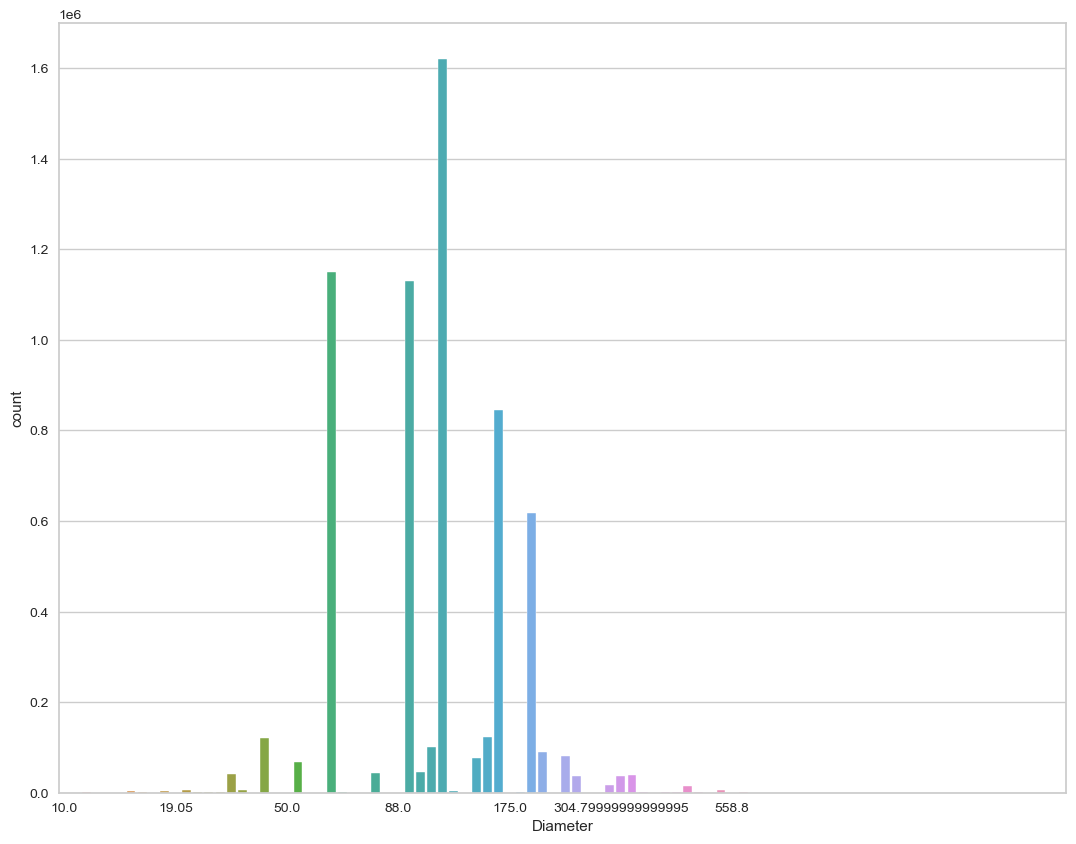

In [40]:
#plot the different diameter of the pipes

f, ax = plt.subplots(figsize=(13,10))
sns.countplot(df_combined['Diameter'])
ax.set_xticks(np.arange(0,100,10))

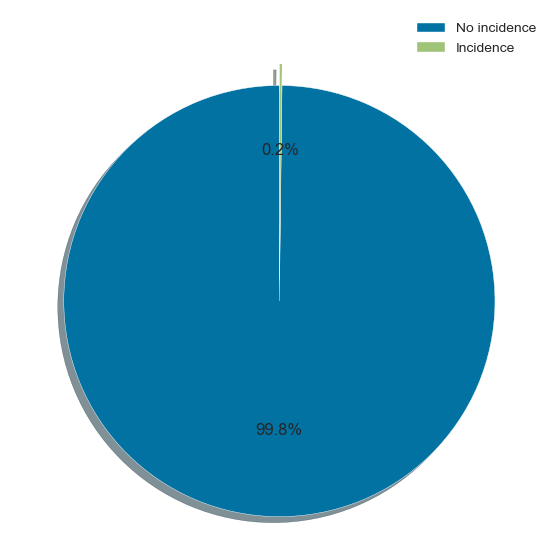

In [41]:
#The following graph shows the percentage of incidence per inspection
fig = plt.figure(figsize =(10, 7))
explode = (0.1 , 0.0)
plt.pie(df_combined.Incidence.value_counts(normalize=True),explode = explode, autopct='%1.1f%%',shadow = True,startangle=90)
plt.legend(['No incidence', 'Incidence'])
# show plot
plt.show()

In [42]:
#General number of inspection per year 
df_combined[['Incidence','InspectionYear']].groupby(['InspectionYear']).count()

,Incidence
InspectionYear,
2010,93518
2011,528113
2012,611594
2013,581559
2014,593223
2015,617187
2016,627667
2017,684715
2018,654861


In [43]:
#General number of inspection per year 
#df_combined[['Incidence','InspectionYear']].groupby(['da']).count()

#please clarify

# Univariate analysis

In [44]:
# Custom function for easy visualisation of Categorical Variables
def UVA_category(data, var_group):
    '''
    Univariate_Analysis_categorical
    takes a group of variables (category) and plot/print all the value_counts and barplot.
    '''
    # setting figure_size
    size = len(var_group)
    plt.figure(figsize=(40, 30))

    # for every variable
    for j, i in enumerate(var_group):
        norm_count = data[i].value_counts(normalize=True)
        n_uni = data[i].nunique()

    # Plotting the variable with every information
        plt.subplot(1, size, j+1)
        ax = sns.barplot(norm_count, norm_count.index, order=norm_count.index)
        ax.bar_label(ax.containers[0], size=20, fmt='%.2f')
        plt.xlabel('fraction/percent', fontsize=20)
        plt.ylabel('{}'.format(i), fontsize=20)

In [45]:
#UVA_category(df_combined,'Diameter')

#Please clarify

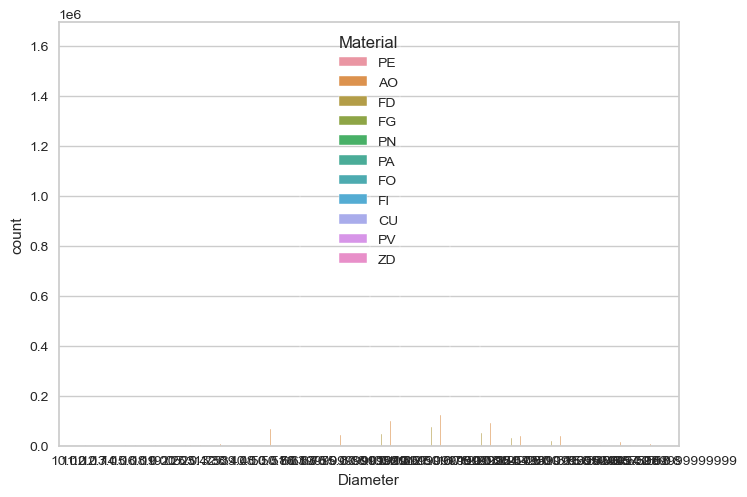

In [46]:
#plot severity per diameter and material type taking dummified columns starting with Material
for i in df_combined.columns:
    if 'Material' in i:
        sns.countplot(x='Diameter', hue=i, data=df_combined)
        plt.show()

[Text(0, 0, '1901'),
 Text(1, 0, '1912'),
 Text(2, 0, '1914'),
 Text(3, 0, '1920'),
 Text(4, 0, '1923'),
 Text(5, 0, '1925'),
 Text(6, 0, '1926'),
 Text(7, 0, '1927'),
 Text(8, 0, '1928'),
 Text(9, 0, '1929'),
 Text(10, 0, '1930'),
 Text(11, 0, '1932'),
 Text(12, 0, '1934'),
 Text(13, 0, '1936'),
 Text(14, 0, '1937'),
 Text(15, 0, '1938'),
 Text(16, 0, '1940'),
 Text(17, 0, '1941'),
 Text(18, 0, '1943'),
 Text(19, 0, '1944'),
 Text(20, 0, '1949'),
 Text(21, 0, '1950'),
 Text(22, 0, '1951'),
 Text(23, 0, '1952'),
 Text(24, 0, '1953'),
 Text(25, 0, '1954'),
 Text(26, 0, '1955'),
 Text(27, 0, '1956'),
 Text(28, 0, '1957'),
 Text(29, 0, '1958'),
 Text(30, 0, '1959'),
 Text(31, 0, '1960'),
 Text(32, 0, '1961'),
 Text(33, 0, '1962'),
 Text(34, 0, '1963'),
 Text(35, 0, '1964'),
 Text(36, 0, '1965'),
 Text(37, 0, '1966'),
 Text(38, 0, '1967'),
 Text(39, 0, '1968'),
 Text(40, 0, '1969'),
 Text(41, 0, '1970'),
 Text(42, 0, '1971'),
 Text(43, 0, '1972'),
 Text(44, 0, '1973'),
 Text(45, 0, '1974')

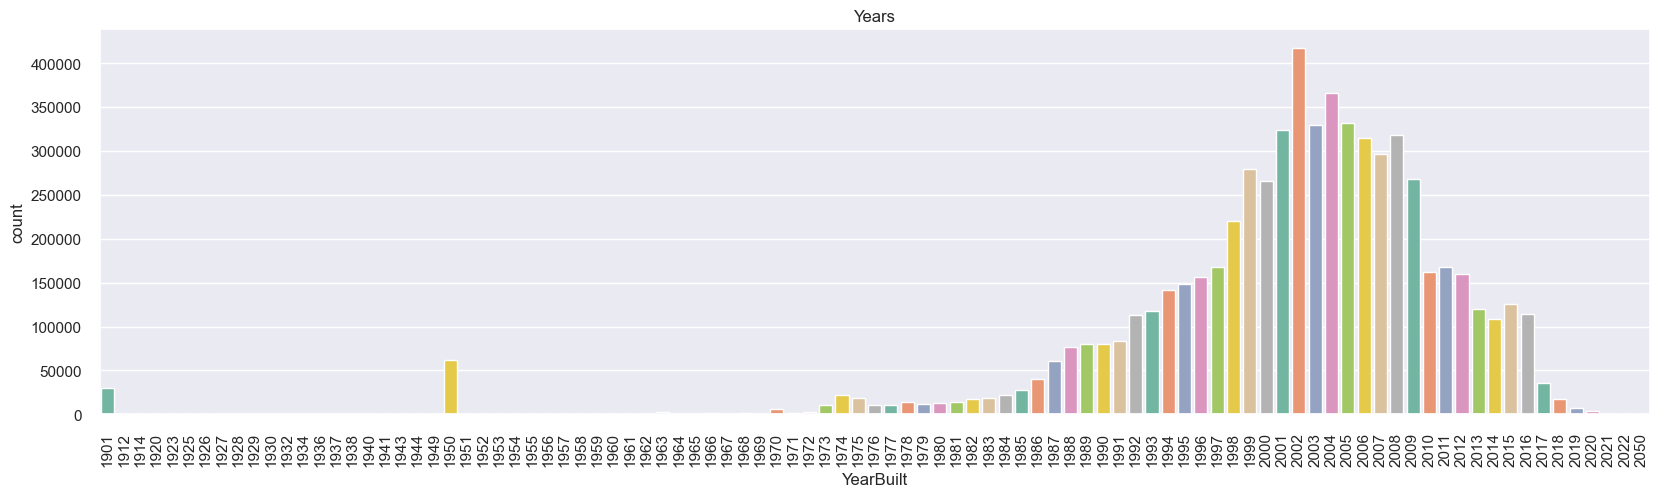

In [47]:
# Plotting class Distribution in Training Data
sns.set_theme(style="darkgrid")
plt.figure(figsize=(20,5))
chart = sns.countplot(x='YearBuilt',data=df_combined, palette="Set2")
plt.xticks(rotation=180)
plt.title('Years')
chart.set_xticklabels(chart.get_xticklabels(), rotation=90)

In [48]:
#Function Definition
def BVA_category(data, Target, feature):

    # Using different plots
    fig, ax = plt.subplots(2, 2, figsize=(25, 25))
    fig.tight_layout(h_pad=3, w_pad=3)

    # define subplot titles
    ax1 = ax[0, 0]
    ax[0, 0].set_title('Bar Plot', size = 12)
    ax2 = ax[0, 1]
    ax[0, 1].set_title('Density Plot', size = 12)
    ax3 = ax[1, 0]
    ax[1, 0].set_title('Violin Plot', size = 12)
    ax4 = ax[1, 1]
    ax[1, 1].set_title('Box Plot',size = 12)
    
 

    # add overall title and adjust it so that it doesn't overlap with subplot titles
    plt.subplots_adjust(top=0.95)
    sns.barplot(x = Target, y=feature, data=data, palette="Set2", ax=ax1)
    sns.kdeplot(data=data, x=feature, hue=Target, alpha=0.2,
                fill=True, legend=True, ax=ax2, palette="Set2")
    sns.violinplot(data=data, x = Target, y=feature, linewidth=0.5, palette="Set2", ax=ax3)
    sns.boxplot(data=data, x=Target, y=feature,
                width=0.2, palette="Set2", ax=ax4)
    plt.show()

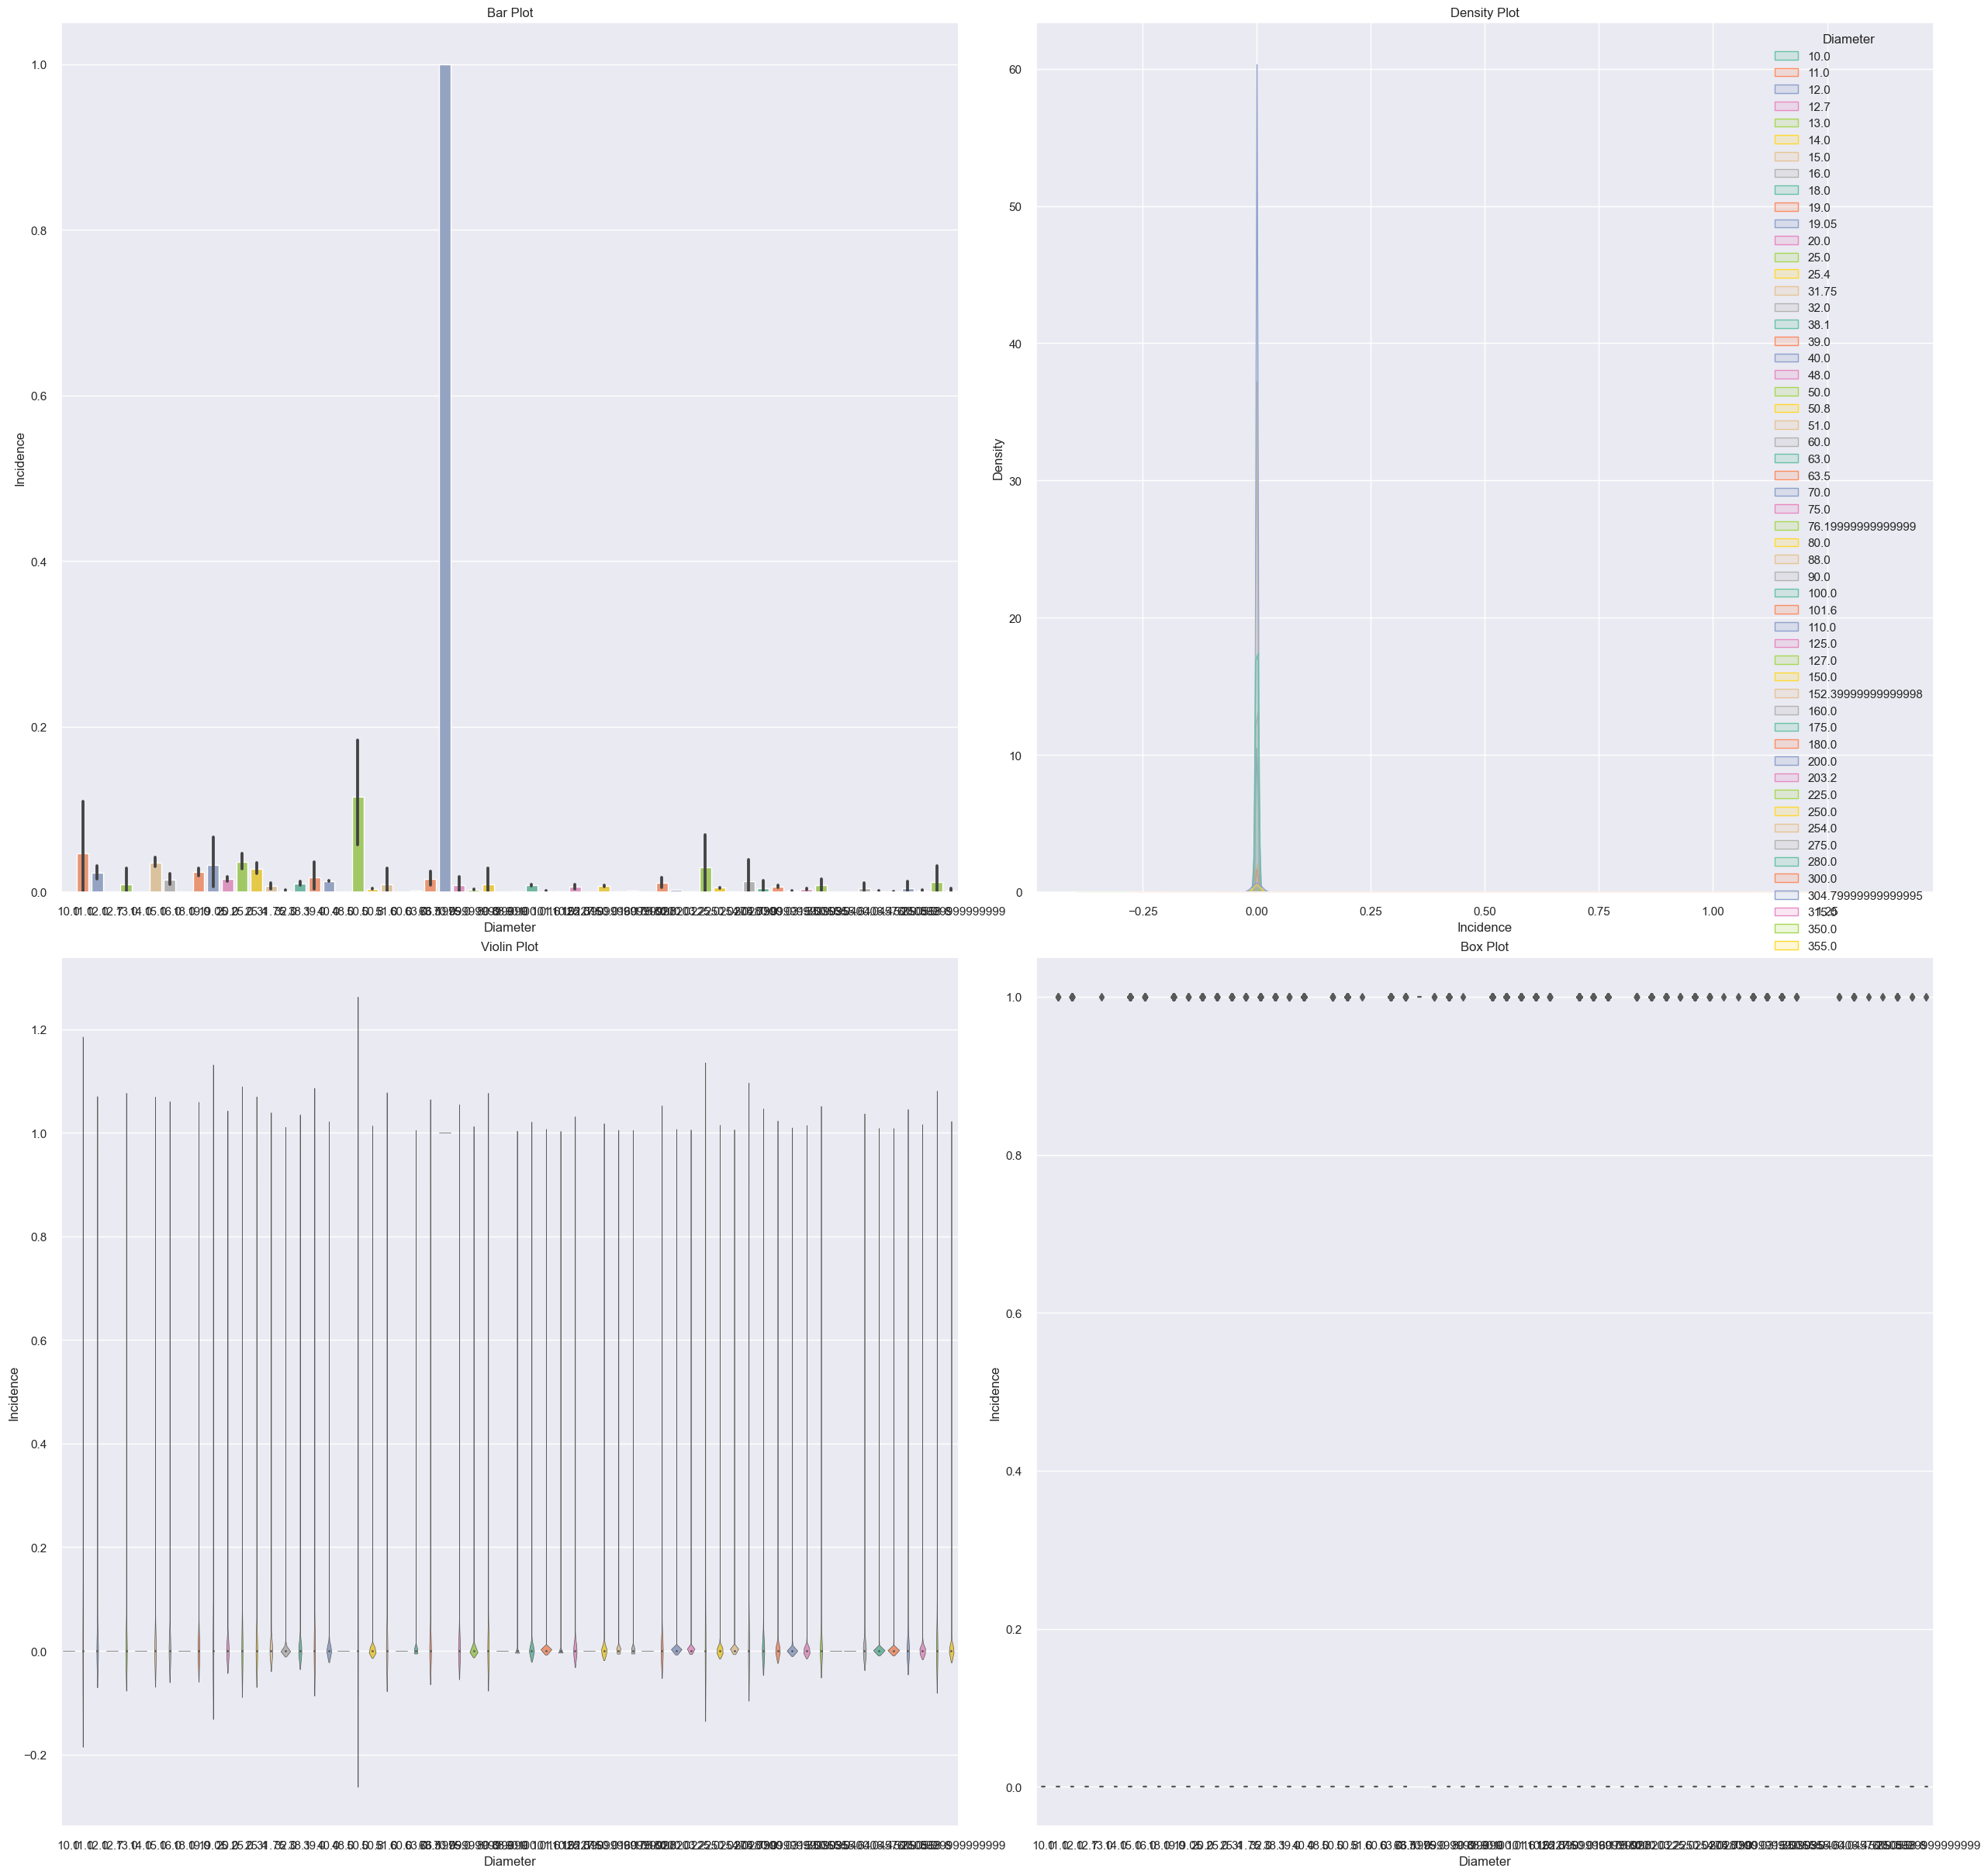

In [49]:
BVA_category(df_combined, 'Diameter', 'Incidence')

In [50]:
df_combined_mod.dtypes

PipeId                                               int64
MaintenanceId                                       object
InspectionYear                                       int64
InspectionDate                              datetime64[ns]
MonthsLastRev                                        int64
Incidence                                            int64
Province                                            object
Town                                                object
YearBuilt                                            int64
Diameter                                           float64
Length                                             float64
Pressure                                           float64
NumConnections                                       int64
NumConnectionsUnder                                  int64
BoolBridle                                           int64
GasType_Gas natural                                  uint8
GasType_Gas propano                                  uin

# Feature Engineering
### I did some before as well so I need to rearrange
#### its 2 AM :')

In [51]:
#create a new column that divides the diameter by the pressure and name it Relative Thickness
df_combined_mod['Relative_Thickness'] = df_combined_mod['Diameter'] / df_combined_mod['Pressure']

In [52]:
df_combined_mod.head(2)

,PipeId,MaintenanceId,InspectionYear,InspectionDate,MonthsLastRev,Incidence,Province,Town,YearBuilt,Diameter,Length,Pressure,NumConnections,NumConnectionsUnder,BoolBridle,GasType_Gas natural,GasType_Gas propano,Material_Acrylonitrile-Butadiene-Styrene,Material_Copper,Material_Fiberglass,Material_Fiberglass-Reinforced Plastic,Material_Flexible Polyolefin,Material_Flexible Polyvinyl Chloride,Material_Polyamide,Material_Polyethylene,Material_Polypropylene,Material_Polyvinylidene Fluoride,Material_Zinc-Coated Steel,Severity_Low,Severity_Medium,Severity_High,Severity_Critical,Age_of_Pipe,Relative_Thickness
0,189311802,ZRV-00001972,2010,2010-10-01,24,0,Barcelona,Sentmenat,2001,160.0,117.831,4.0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,22,40.0
1,189311802,ZRV-00001972,2012,2012-10-01,24,0,Barcelona,Sentmenat,2001,160.0,117.831,4.0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,22,40.0


# Baseline for df_combined alone 
df__combined_mod reached 86% and locked after230 min

In [54]:
#make a new dataframe removing columns that are not needed for the model from the df_combined_mod dataframe
df_model = df_combined_mod.drop(['InspectionYear', 'MaintenanceId', 'Province', 'Town', 'InspectionDate'], axis=1)


In [55]:
df_model.head(2)

,PipeId,MonthsLastRev,Incidence,YearBuilt,Diameter,Length,Pressure,NumConnections,NumConnectionsUnder,BoolBridle,GasType_Gas natural,GasType_Gas propano,Material_Acrylonitrile-Butadiene-Styrene,Material_Copper,Material_Fiberglass,Material_Fiberglass-Reinforced Plastic,Material_Flexible Polyolefin,Material_Flexible Polyvinyl Chloride,Material_Polyamide,Material_Polyethylene,Material_Polypropylene,Material_Polyvinylidene Fluoride,Material_Zinc-Coated Steel,Severity_Low,Severity_Medium,Severity_High,Severity_Critical,Age_of_Pipe,Relative_Thickness
0,189311802,24,0,2001,160.0,117.831,4.0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,22,40.0
1,189311802,24,0,2001,160.0,117.831,4.0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,22,40.0


In [56]:
#split df_combined_mod into train and test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_model.drop(['Incidence'], axis=1), df_model['Incidence'], test_size=0.2, random_state=42)


In [57]:
#use lazy predict to create a baseline with all possible models
from lazypredict.Supervised import LazyClassifier
clf = LazyClassifier(verbose=1, ignore_warnings=False, custom_metric=None)
models, predictions = clf.fit(X_train, X_test, y_train, y_test)
models

  3%|▎         | 1/29 [00:12<05:58, 12.80s/it]

{'Model': 'AdaBoostClassifier', 'Accuracy': 1.0, 'Balanced Accuracy': 1.0, 'ROC AUC': 1.0, 'F1 Score': 1.0, 'Time taken': 12.795071363449097}


  7%|▋         | 2/29 [01:08<17:05, 37.99s/it]

{'Model': 'BaggingClassifier', 'Accuracy': 1.0, 'Balanced Accuracy': 1.0, 'ROC AUC': 1.0, 'F1 Score': 1.0, 'Time taken': 55.61998963356018}


 10%|█         | 3/29 [01:16<10:30, 24.23s/it]

{'Model': 'BernoulliNB', 'Accuracy': 1.0, 'Balanced Accuracy': 1.0, 'ROC AUC': 1.0, 'F1 Score': 1.0, 'Time taken': 7.86034369468689}


In [65]:
#split df_combined_mod into train and test set
#from sklearn.model_selection import train_test_split
#X_train, X_test, y_train, y_test = train_test_split(df_combined_mod.drop(['Incidence'], axis=1), df_combined_mod['Incidence'], test_size=0.2, random_state=42)


In [67]:
#use lazy predict to create a baseline with all possible models
#from lazypredict.Supervised import LazyClassifier
#clf = LazyClassifier(verbose=1, ignore_warnings=False, custom_metric=None)
#models, predictions = clf.fit(X_train, X_test, y_train, y_test)
#models

 86%|████████▌ | 25/29 [35:56<05:54, 88.59s/it]  

# DO NOT TOUCH SECTION :)
# After creating baseline, normalizing and stratyfing, in that order

In [64]:
df_combined_mod_norm = df_combined_mod.copy()

In [ ]:
#apply normalization and standardization to the df_combined_mod_norm dataframe
for i in df_combined_mod_norm.columns:
    if 'Material' in i:
        df_combined_mod_norm[i] = (df_combined_mod_norm[i] - df_combined_mod_norm[i].mean()) / df_combined_mod_norm[i].std()
    if 'Severity' in i:
        df_combined_mod_norm[i] = (df_combined_mod_norm[i] - df_combined_mod_norm[i].mean()) / df_combined_mod_norm[i].std()
    if 'Incidence' in i:
        df_combined_mod_norm[i] = (df_combined_mod_norm[i] - df_combined_mod_norm[i].mean()) / df_combined_mod_norm[i].std()
    if 'Age_of_Pipe' in i:
        df_combined_mod_norm[i] = (df_combined_mod_norm[i] - df_combined_mod_norm[i].mean()) / df_combined_mod_norm[i].std()
    if 'Relative_Thickness' in i:
        df_combined_mod_norm[i] = (df_combined_mod_norm[i] - df_combined_mod_norm[i].mean()) / df_combined_mod_norm[i].std()
    if 'Diameter' in i:
        df_combined_mod_norm[i] = (df_combined_mod_norm[i] - df_combined_mod_norm[i].mean()) / df_combined_mod_norm[i].std()
    if 'Pressure' in i:
        df_combined_mod_norm[i] = (df_combined_mod_norm[i] - df_combined_mod_norm[i].mean()) / df_combined_mod_norm[i].std()
    if 'YearBuilt' in i:
        df_combined_mod_norm[i] = (df_combined_mod_norm[i] - df_combined_mod_norm[i].mean()) / df_combined_mod_norm[i].std()
    if 'InspectionYear' in i:
        df_combined_mod_norm[i] = (df_combined_mod_norm[i] - df_combined_mod_norm[i].mean()) / df_combined_mod_norm[i].std()
    if 'Material_Cast Iron' in i:
        df_combined_mod_norm[i] = (df_combined_mod_norm[i] - df_combined_mod_norm[i].mean()) / df_combined_mod_norm[i].std()
    if 'Material_Concrete' in i:
        df_combined_mod_norm[i] = (df_combined_mod_norm[i] - df_combined_mod_norm[i].mean()) / df_combined_mod_norm[i].std()
    if 'Material_Fiberglass' in i:
        df_combined_mod_norm[i] = (df_combined_mod_norm

In [63]:
#apply synthetic minority oversampling technique to balance the data ignoring categorical variables
from imblearn.over_sampling import SMOTE
smote = SMOTE(sampling_strategy='minority', random_state=0)
X_sm, y_sm = smote.fit_resample(df_combined_mod.drop(['Incidence'], axis=1), df_combined_mod['Incidence'])


ValueError: could not convert string to float: 'ZRV-00001972'